In [1]:
import pandas
import numpy
import re
import sklearn.preprocessing
import sklearn.neighbors
from sklearn.ensemble import RandomForestClassifier
import sklearn.neural_network
import sklearn.feature_selection
from sklearn.model_selection import cross_val_score
from scipy import stats

# Modify this to point to your data.
diabetes_data = pandas.read_csv('diabetes.csv', sep = ",")
diabetes_data

Age  Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0     40    Male       No        Yes                 No      Yes         No   
1     58    Male       No         No                 No      Yes         No   
2     41    Male      Yes         No                 No      Yes        Yes   
3     45    Male       No         No                Yes      Yes        Yes   
4     60    Male      Yes        Yes                Yes      Yes        Yes   
..   ...     ...      ...        ...                ...      ...        ...   
515   39  Female      Yes        Yes                Yes       No        Yes   
516   48  Female      Yes        Yes                Yes      Yes        Yes   
517   58  Female      Yes        Yes                Yes      Yes        Yes   
518   32  Female       No         No                 No      Yes         No   
519   42    Male       No         No                 No       No         No   

    Genital thrush visual blurring Itching Irritability delayed healing  \
0               No              No     Yes           No             Yes   
1               No             Yes      No           No              No   
2               No              No     Yes           No             Yes   
3              Yes              No     Yes           No             Yes   
4               No             Yes     Yes          Yes             Yes   
..             ...             ...     ...          ...             ...   
515             No              No     Yes           No             Yes   
516             No              No     Yes          Yes             Yes   
517             No             Yes      No           No              No   
518             No             Yes     Yes           No             Yes   
519             No              No      No           No              No   

    partial paresis muscle stiffness Alopecia Obesity     class  
0                No              Yes      Yes     Yes  Positive  
1               Yes               No      Yes      No  Positive  
2                No              Yes      Yes      No  Positive  
3                No               No       No      No  Positive  
4               Yes              Yes      Yes     Yes  Positive  
..              ...              ...      ...     ...       ...  
515             Yes               No       No      No  Positive  
516             Yes               No       No      No  Positive  
517             Yes              Yes       No     Yes  Positive  
518              No               No      Yes      No  Negative  
519              No               No       No      No  Negative  

[520 rows x 17 columns]

In [2]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

# Part 1: Data Cleaning

As always, we should start with data cleaning.
Take what you learned from HO3 to clean up this messy data to a point where it is ready for machine learning algorithms.

Some things you may want to do:
 - Deal with missing/empty values.
 - Fix numeric columns so that they actually contain numbers.
 - Remove inconsistencies from columns.
 - Assign a data type to each column.

In [3]:
# helper function: guess_type(frame)
# guesses the type of each col in frame, and sets the col dtype to that
# note that this was taken directly from my HO3 (i feel like i should include that in my report)
def guess_type(frame):
    # go through each column
    # go through each entry
    # if type(entry) returns a string, set col to string and exit that loop
    # have a boolean that checks for floats; if at the end that returns true, cast column to float
    # if at the end it returns false, cast col to int
    hasFloat = False
    hasString = False
    for col in frame.columns:
        hasString = False
        hasFloat = False
        for entry in frame[col]:
            if isinstance(entry, str):
                hasString = True
                break
            if isinstance(entry, float):
                hasFloat = True
        if hasString:
            frame[col] = frame[col].astype(str)
        elif hasFloat:
            frame[col] = frame[col].astype(float)
        else:  # int
            frame[col] = frame[col].astype(int)
    return frame


In [4]:
# according to the autograder we don't need this so...
def one_hot_encoding(frame):
    # go through all the cols
    for col in frame.columns:
        # if the col is of type string, do one hot encoding
        if frame[col].dtype == object:
            one_hot_col = pandas.get_dummies(frame[col], prefix=col)
            one_hot_col = one_hot_col[one_hot_col.columns[1]]
            
            # concattenate that new frame back into the main frame
            frame = pandas.concat([frame, one_hot_col], axis = 1)
            frame.pop(col)
    return frame

In [5]:
# need to scale the data before running it through the classifier;
# but can't scale the label column
def scale_data(frame, label):

    df = frame.copy(deep=True).drop(label, axis=1)
    cols = df.columns
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(df)
    #df = scaler.transform(df)
    #scaler = sklearn.preprocessing.StandardScaler()
    #scaler.fit(df)
    df = scaler.transform(df)

    df = df.T  # transpose; instead of each sub array representing a row, it represents a column
    scaledData = frame.copy(deep=True)
    for i, col in enumerate(cols):
        scaledData[col] = df[i]
    return scaledData

In [6]:
def clean_data(frame):
    clean_data = {}
    for col in frame.columns:  # looping through col
        clean_data[col] = []
        for i, entry in enumerate(frame[col]):  # looping through each entry in the col
            value = None

            # checking null values
            if (re.search(r"N\/A|\?|None|^nan", str(entry)) or len(str(entry)) == 0):
                value = numpy.nan

            # if entry has a number in it
            elif (re.search(r"\d+", str(entry))):
                value = re.search(r"\-?\d+\.*\d*", str(entry))[0]  # remove string stuff
                if ("." in str(value)):  # contains decimal -> is a float
                    value = float(value)
                else:  # else -> it's an int
                    value = int(value)
             
            # entry doesn't have any numbers -> it's a string
            else:
                value = entry.upper()  # to make it consistent, make it all caps
                if ("," in value):  # special case where there's 2 locations listed
                    value = re.search(r"(\D+)\,", value).group(1)  # only take the first location
            
            clean_data[col].append(value)
            
    clean_frame = pandas.DataFrame(clean_data)

    # set the data types
    clean_frame = guess_type(clean_frame)
    
    # do one hot encoding on string cols
    clean_frame = one_hot_encoding(clean_frame)

    # scale data (age col)
    clean_frame = scale_data(clean_frame, "class_POSITIVE")

    # convert bools to ints
    for col in clean_frame.columns:
        if clean_frame[col].dtype == bool:
            clean_frame[col] = clean_frame[col].astype(int)


    return clean_frame

diabetes_data = clean_data(diabetes_data)
diabetes_data

Age  Gender_MALE  Polyuria_YES  Polydipsia_YES  \
0    0.324324          1.0           0.0             1.0   
1    0.567568          1.0           0.0             0.0   
2    0.337838          1.0           1.0             0.0   
3    0.391892          1.0           0.0             0.0   
4    0.594595          1.0           1.0             1.0   
..        ...          ...           ...             ...   
515  0.310811          0.0           1.0             1.0   
516  0.432432          0.0           1.0             1.0   
517  0.567568          0.0           1.0             1.0   
518  0.216216          0.0           0.0             0.0   
519  0.351351          1.0           0.0             0.0   

     sudden weight loss_YES  weakness_YES  Polyphagia_YES  Genital thrush_YES  \
0                       0.0           1.0             0.0                 0.0   
1                       0.0           1.0             0.0                 0.0   
2                       0.0           1.0             1.0                 0.0   
3                       1.0           1.0             1.0                 1.0   
4                       1.0           1.0             1.0                 0.0   
..                      ...           ...             ...                 ...   
515                     1.0           0.0             1.0                 0.0   
516                     1.0           1.0             1.0                 0.0   
517                     1.0           1.0             1.0                 0.0   
518                     0.0           1.0             0.0                 0.0   
519                     0.0           0.0             0.0                 0.0   

     visual blurring_YES  Itching_YES  Irritability_YES  delayed healing_YES  \
0                    0.0          1.0               0.0                  1.0   
1                    1.0          0.0               0.0                  0.0   
2                    0.0          1.0               0.0                  1.0   
3                    0.0          1.0               0.0                  1.0   
4                    1.0          1.0               1.0                  1.0   
..                   ...          ...               ...                  ...   
515                  0.0          1.0               0.0                  1.0   
516                  0.0          1.0               1.0                  1.0   
517                  1.0          0.0               0.0                  0.0   
518                  1.0          1.0               0.0                  1.0   
519                  0.0          0.0               0.0                  0.0   

     partial paresis_YES  muscle stiffness_YES  Alopecia_YES  Obesity_YES  \
0                    0.0                   1.0           1.0          1.0   
1                    1.0                   0.0           1.0          0.0   
2                    0.0                   1.0           1.0          0.0   
3                    0.0                   0.0           0.0          0.0   
4                    1.0                   1.0           1.0          1.0   
..                   ...                   ...           ...          ...   
515                  1.0                   0.0           0.0          0.0   
516                  1.0                   0.0           0.0          0.0   
517                  1.0                   1.0           0.0          1.0   
518                  0.0                   0.0           1.0          0.0   
519                  0.0                   0.0           0.0          0.0   

     class_POSITIVE  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
515               1  
516               1  
517               1  
518               0  
519               0  

[520 rows x 17 columns]

In [7]:
diabetes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     520 non-null    float64
 1   Gender_MALE             520 non-null    float64
 2   Polyuria_YES            520 non-null    float64
 3   Polydipsia_YES          520 non-null    float64
 4   sudden weight loss_YES  520 non-null    float64
 5   weakness_YES            520 non-null    float64
 6   Polyphagia_YES          520 non-null    float64
 7   Genital thrush_YES      520 non-null    float64
 8   visual blurring_YES     520 non-null    float64
 9   Itching_YES             520 non-null    float64
 10  Irritability_YES        520 non-null    float64
 11  delayed healing_YES     520 non-null    float64
 12  partial paresis_YES     520 non-null    float64
 13  muscle stiffness_YES    520 non-null    float64
 14  Alopecia_YES            520 non-null    fl

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender_MALE'}>,
        <Axes: title={'center': 'Polyuria_YES'}>,
        <Axes: title={'center': 'Polydipsia_YES'}>],
       [<Axes: title={'center': 'sudden weight loss_YES'}>,
        <Axes: title={'center': 'weakness_YES'}>,
        <Axes: title={'center': 'Polyphagia_YES'}>,
        <Axes: title={'center': 'Genital thrush_YES'}>],
       [<Axes: title={'center': 'visual blurring_YES'}>,
        <Axes: title={'center': 'Itching_YES'}>,
        <Axes: title={'center': 'Irritability_YES'}>,
        <Axes: title={'center': 'delayed healing_YES'}>],
       [<Axes: title={'center': 'partial paresis_YES'}>,
        <Axes: title={'center': 'muscle stiffness_YES'}>,
        <Axes: title={'center': 'Alopecia_YES'}>,
        <Axes: title={'center': 'Obesity_YES'}>],
       [<Axes: title={'center': 'class_POSITIVE'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

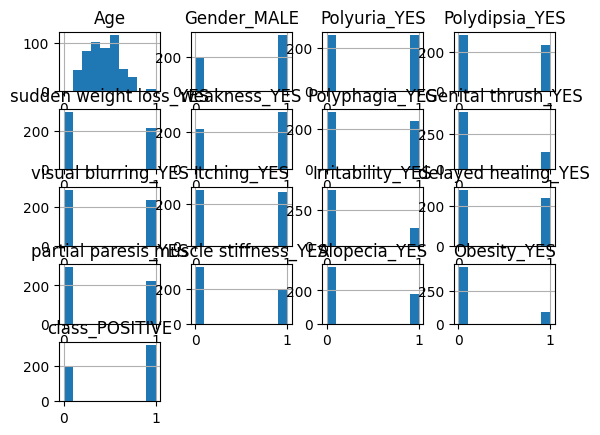

In [8]:
diabetes_data.hist()

In [9]:
diabetes_data["Obesity_YES"].dtype == bool

False

<Axes: >

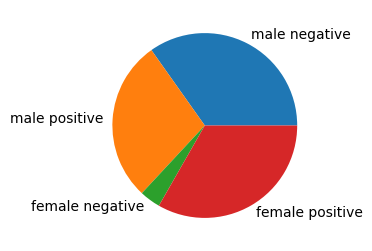

In [10]:
gender_data = {
    "male negative": len(diabetes_data[(diabetes_data["Gender_MALE"] == 1) & (diabetes_data["class_POSITIVE"] == 0)]),
    "male positive": len(diabetes_data[(diabetes_data["Gender_MALE"] == 1) & (diabetes_data["class_POSITIVE"] == 1)]),
    "female negative": len(diabetes_data[(diabetes_data["Gender_MALE"] == 0) & (diabetes_data["class_POSITIVE"] == 0)]),
    "female positive": len(diabetes_data[(diabetes_data["Gender_MALE"] == 0) & (diabetes_data["class_POSITIVE"] == 1)])
}

all = pandas.Series(gender_data.values(), index=gender_data.keys())
all.plot.pie(figsize=(6, 3))

<Axes: >

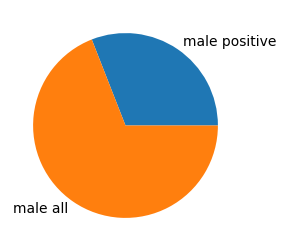

In [11]:
male = pandas.Series([gender_data["male positive"], len(diabetes_data[diabetes_data["Gender_MALE"] == 1])], index=["male positive", "male all"])
male.plot.pie(figsize=(3, 3))

<Axes: >

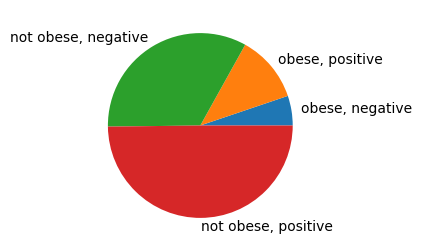

In [12]:
col = "Obesity_YES"
obesity_data = {
    "obese, negative": len(diabetes_data[(diabetes_data[col] == 1) & (diabetes_data["class_POSITIVE"] == 0)]),
    "obese, positive": len(diabetes_data[(diabetes_data[col] == 1) & (diabetes_data["class_POSITIVE"] == 1)]),
    "not obese, negative": len(diabetes_data[(diabetes_data[col] == 0) & (diabetes_data["class_POSITIVE"] == 0)]),
    "not obese, positive": len(diabetes_data[(diabetes_data[col] == 0) & (diabetes_data["class_POSITIVE"] == 1)])
}

all = pandas.Series(obesity_data.values(), index=obesity_data.keys())
all.plot.pie(figsize=(6, 3))

# Part 3: Modeling

Now that you have a good grasp of your clean data,
it is time to do some machine learning!
(Technically all our previous steps were also machine learning,
but now we get to use classifiers!)

Use the skills you developed to select **three** classifiers and implement them on your data.
For example, you can narrow down your choices to three classifiers which may include:
- Logistic regression
- K-nearest neighbors
- Decision tree
- Or others

In [13]:
def create_classifiers():
    neighbor = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    tree = RandomForestClassifier(max_depth=20, n_estimators=10, max_features=1, random_state=42)
    neural = sklearn.neural_network.MLPClassifier(alpha=1, max_iter=1000, random_state=42)
    return [neighbor, tree, neural]

my_classifiers = create_classifiers()
my_classifiers

[KNeighborsClassifier(n_neighbors=3),
 RandomForestClassifier(max_depth=20, max_features=1, n_estimators=10,
                        random_state=42),
 MLPClassifier(alpha=1, max_iter=1000, random_state=42)]

In [14]:
# returns the columns that pass the relevancy/correlation threshold
def choose_columns(features, label, threshold):
    copy = features.copy(deep=True)

    coefficients = sklearn.feature_selection.r_regression(features, label)
    for i, coef in enumerate(coefficients):
        # if the coefficient doesn't reach the threshold, remove it from copy
        if abs(coef) < threshold:
            print("irrelevant:", features.columns[i])
            copy.pop(features.columns[i])
    return copy

In [15]:
diabetes_data

Age  Gender_MALE  Polyuria_YES  Polydipsia_YES  \
0    0.324324          1.0           0.0             1.0   
1    0.567568          1.0           0.0             0.0   
2    0.337838          1.0           1.0             0.0   
3    0.391892          1.0           0.0             0.0   
4    0.594595          1.0           1.0             1.0   
..        ...          ...           ...             ...   
515  0.310811          0.0           1.0             1.0   
516  0.432432          0.0           1.0             1.0   
517  0.567568          0.0           1.0             1.0   
518  0.216216          0.0           0.0             0.0   
519  0.351351          1.0           0.0             0.0   

     sudden weight loss_YES  weakness_YES  Polyphagia_YES  Genital thrush_YES  \
0                       0.0           1.0             0.0                 0.0   
1                       0.0           1.0             0.0                 0.0   
2                       0.0           1.0             1.0                 0.0   
3                       1.0           1.0             1.0                 1.0   
4                       1.0           1.0             1.0                 0.0   
..                      ...           ...             ...                 ...   
515                     1.0           0.0             1.0                 0.0   
516                     1.0           1.0             1.0                 0.0   
517                     1.0           1.0             1.0                 0.0   
518                     0.0           1.0             0.0                 0.0   
519                     0.0           0.0             0.0                 0.0   

     visual blurring_YES  Itching_YES  Irritability_YES  delayed healing_YES  \
0                    0.0          1.0               0.0                  1.0   
1                    1.0          0.0               0.0                  0.0   
2                    0.0          1.0               0.0                  1.0   
3                    0.0          1.0               0.0                  1.0   
4                    1.0          1.0               1.0                  1.0   
..                   ...          ...               ...                  ...   
515                  0.0          1.0               0.0                  1.0   
516                  0.0          1.0               1.0                  1.0   
517                  1.0          0.0               0.0                  0.0   
518                  1.0          1.0               0.0                  1.0   
519                  0.0          0.0               0.0                  0.0   

     partial paresis_YES  muscle stiffness_YES  Alopecia_YES  Obesity_YES  \
0                    0.0                   1.0           1.0          1.0   
1                    1.0                   0.0           1.0          0.0   
2                    0.0                   1.0           1.0          0.0   
3                    0.0                   0.0           0.0          0.0   
4                    1.0                   1.0           1.0          1.0   
..                   ...                   ...           ...          ...   
515                  1.0                   0.0           0.0          0.0   
516                  1.0                   0.0           0.0          0.0   
517                  1.0                   1.0           0.0          1.0   
518                  0.0                   0.0           1.0          0.0   
519                  0.0                   0.0           0.0          0.0   

     class_POSITIVE  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
515               1  
516               1  
517               1  
518               0  
519               0  

[520 rows x 17 columns]

In [16]:
def cross_fold_validation(classifier, frame, folds):
    
    features = frame.drop("class_POSITIVE", axis=1)
    label = frame["class_POSITIVE"]
    features = choose_columns(features, label, 0.005)
    
    accuracy_scores = cross_val_score(classifier, features, label, cv=folds, scoring="accuracy")
    return accuracy_scores.tolist()

my_classifiers_scores = []
shuffled = diabetes_data.sample(frac=1, random_state=0)
for classifier in my_classifiers:
    #accuracy_scores = cross_fold_validation(classifier, diabetes_data, 5)
    accuracy_scores = cross_fold_validation(classifier, shuffled, 5)
    my_classifiers_scores.append(accuracy_scores)
    print("Classifier: %s, Accuracy: %s." % (type(classifier).__name__, accuracy_scores))
    print("average accuracy:", sum(accuracy_scores)/5)

Classifier: KNeighborsClassifier, Accuracy: [0.9711538461538461, 0.9615384615384616, 0.9711538461538461, 0.9326923076923077, 0.9326923076923077].
average accuracy: 0.9538461538461538
Classifier: RandomForestClassifier, Accuracy: [0.9903846153846154, 0.9711538461538461, 0.9903846153846154, 0.9711538461538461, 0.9807692307692307].
average accuracy: 0.9807692307692308
Classifier: MLPClassifier, Accuracy: [0.9423076923076923, 0.8846153846153846, 0.9230769230769231, 0.9134615384615384, 0.9230769230769231].
average accuracy: 0.9173076923076924


In [55]:
def significance_test(a_values, b_values, p_value):
    sig = stats.ttest_ind(a_values, b_values)[1]
    
    return sig < p_value

for i in range(len(my_classifiers)):
    for j in range(i + 1, len(my_classifiers)):
        significant = significance_test(my_classifiers_scores[i], my_classifiers_scores[j], 0.10)
        print("%s vs %s: %s" % (type(my_classifiers[i]).__name__,
                                type(my_classifiers[j]).__name__, significant))

KNeighborsClassifier vs RandomForestClassifier: False
KNeighborsClassifier vs MLPClassifier: False
RandomForestClassifier vs MLPClassifier: False
